APAGAR DEPOIS


Requisitos:
- Identificar a localização desenhando um Bounding-Box ao redor da moeda
- Informar o valor da moeda
- Apresentar o desempenho do algoritmo
- Matriz de Confusão e Percentual
- Análise de erros
- Deve-se utilizar um algoritmo de machine learning (KNN, SVM)
- Não é permitido o uso de Deep Learning


comentar funções



# TDE01 - DIGITAR INFO




FALAR SOBRE IMPORTS




In [317]:
%matplotlib inline

import os, cv2, random, numpy as np, matplotlib.pyplot as plt, seaborn as sns

from google.colab.patches import cv2_imshow # for image display

from skimage import io, util
from skimage.transform import resize
from skimage.color import rgb2gray, rgb2hsv
from skimage.filters import threshold_otsu, threshold_local, median
from skimage.feature import local_binary_pattern
from skimage.morphology import label, closing, square
from skimage.measure import regionprops
from skimage.draw import rectangle_perimeter

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [364]:
!wget https://www.inf.ufpr.br/aghochuli/dataset3.zip -O dataset3.zip
!unzip dataset3.zip

imgs = []

for img_path in os.listdir('./dataset3/'):
    imgs.append([io.imread('./dataset3/' + img_path),img_path])
    
print(len(imgs),"images loaded")

--2021-09-02 19:37:18--  https://www.inf.ufpr.br/aghochuli/dataset3.zip
Resolving www.inf.ufpr.br (www.inf.ufpr.br)... 200.17.202.113, 2801:82:80ff:8001:216:ccff:feaa:79
Connecting to www.inf.ufpr.br (www.inf.ufpr.br)|200.17.202.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35758483 (34M) [application/zip]
Saving to: ‘dataset3.zip’

dataset3.zip        100%[===================>]  34.10M  13.7MB/s    in 2.5s    

2021-09-02 19:37:22 (13.7 MB/s) - ‘dataset3.zip’ saved [35758483/35758483]

Archive:  dataset3.zip
replace dataset3/5_1477189488.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: dataset3/5_1477189488.jpg  
  inflating: dataset3/100_1477280538.jpg  
  inflating: dataset3/50_1477282872.jpg  
  inflating: dataset3/10_1477147452.jpg  
  inflating: dataset3/50_1477283088.jpg  
  inflating: dataset3/10_1477288506.jpg  
  inflating: dataset3/10_1477288476.jpg  
  inflating: dataset3/100_1477281726.jpg  
  inflating: dataset3/5_1477290534.jpg  


### AJUSTE DO DATASET

Falar sobre ajustes e fazer mais ajustes

In [365]:

for i in range(len(imgs)):

    imgs[i][0] = np.array(resize(imgs[i][0], (90, 144), anti_aliasing=True))


## COIN DETECTION

Identificar a localização desenhando um Bounding-Box ao redor da moeda


In [366]:
reddies = []

def bbox(image, dimensions=(90,144)):

    global reddies
    
    resized = resize(image, dimensions, anti_aliasing=True)

    hsv = rgb2hsv(resized)

    channel_s = hsv[:,:,1]

    channel_filtered = median(channel_s, np.ones((3, 3)))

    block_size = 20
    local_thresh = threshold_otsu(channel_filtered, block_size)
    binary_s = channel_filtered > local_thresh

    binary = util.img_as_ubyte(binary_s)

    # label image regions
    label_image = label(binary)

    r = regionprops(label_image)
    
    rect = None
    for region in r:
      
        # skip small images
        if region['Area'] < 60:
            continue
      
        # draw rectangle around segmented coins    
        rect = region['BoundingBox']
      
        ratio = 0
        if  abs(rect[2] - rect[0]) != 0:
            ratio = abs(rect[3] - rect[1]) / abs(rect[2] - rect[0])
        
        #Eliminating non squared bbox 
        if not (0.90 < ratio < 1.10):         
             continue

        reddy = image.copy()
        start, end = (rect[0], rect[1]), (rect[2], rect[3])
        rr, cc = rectangle_perimeter(start=start, extent=end, shape=image.shape)

        reddy[rr, cc] = [255, 0, 0]
        
        reddies.append(reddy)

        return (rect,binary)

    reddies.append(image)

    return (rect, binary)
    

def crop (image, p1, p2):

    return image[ p1[0]+1:p2[0]+1, p1[1]:p2[1] ]

def cutset(imgs, cuts):
    
    ret = []
    for i in range(len(imgs)):

        if cuts[i] == None:
            continue
        
        ret.append(crop(imgs[i][0], [cuts[i][0],cuts[i][1]], [cuts[i][2],cuts[i][3]]) )

    return ret


nimages_to_use = 0
def get_good_imgs(imgs_cutted, imgs):

    global nimages_to_use
    ok = []
    for i in range(len(imgs_cutted)):

        if np.array(imgs_cutted[i]).shape[0] == 0 and np.array(imgs_cutted[i]).shape[1] == 0: 
            continue
          
        ok.append([imgs_cutted[i], imgs[i][1]])

    nimages_to_use = len(ok)
    return ok


In [367]:
 
imgs_rect_cut = [bbox(i[0])[0] for i in imgs]

binaries = [bbox(i[0])[1] for i in imgs]

imgs_cut = cutset(imgs, imgs_rect_cut)

imgs = get_good_imgs(imgs_cut, imgs)


In [434]:


# detalhar as variáveis imgs_rect_cut,  binaries, imgs_cut, imgs, reddies

# mostrar como ele fez usando figure e axes.


995

## SPLIT DO DATASET

In [392]:

# Calculates de frequence of each category in the data.
def frequenceDict(data):

    arr = {}
    for i in data:  # Initializes the category.
        arr[(i[1].split("_")[0])] = 0 

    for i in data:  # Counts the frequence for the category.
        arr[i[1].split("_")[0]] += 1

    return arr


# Maps the amount of items per category per partitions.
def mapdistribution(partitions, freq_dict):

    ret = []

    # Initializes a dictionary for each partition with its distribution.
    for p in partitions:
        ret_ = {}
        for f in freq_dict.keys():
            ret_[f] = int(freq_dict[f] * p) 
        ret.append(ret_)

    return ret


def load_balance_split(data, mapdistribution_):
    
    ret = [ [] for _ in mapdistribution_]

    for d in data:

        for match in range(len(mapdistribution_)):

            if mapdistribution_[match][d[1].split("_")[0]] > 0:

                ret[match].append(d)

                mapdistribution_[match][d[1].split("_")[0]] -= 1

                break

    return (*ret,)

In [437]:

for i in range(len(imgs)):

    #                               aumentar limite do dimensions
    imgs[i][0] = resize(imgs[i][0], (10, 10), anti_aliasing=True)


freqdict = frequenceDict(imgs)
mapd = mapdistribution([0.5, 0.2, 0.3], freqdict)

training, validation, testing = load_balance_split(imgs, mapd)


295

In [498]:

METHOD = 'uniform' #non-uniform || flat
radius = 3
n_points = 8 * radius

def setdata(data):

    data_lbp, data_value = [], []

    for d in data:
        
        data_lbp.append(local_binary_pattern(np.array(rgb2gray(d[0])), n_points, radius, METHOD))
        data_value.append(d[1].split("_")[0])

    return np.array(data_lbp), np.array(data_value).reshape(-1,1)

def prepareDataForModel(data):

    d0nsamples, d0x, d0y = data[0].shape
    d1nsamples, d1x = data[1].shape

    return data[0].reshape((d0nsamples,d0x*d0y,)), data[1].reshape((d1nsamples,d1x))


training_lbp, training_value = prepareDataForModel(setdata(training))
validation_lbp, validation_value = prepareDataForModel(setdata(validation))
testing_lbp, testing_value = prepareDataForModel(setdata(testing))


## MODELOS

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


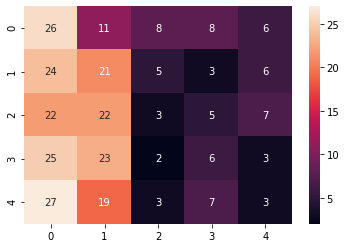

In [499]:
KNN = KNeighborsClassifier(n_neighbors=3)

KNN.fit(training_lbp, training_value)


preds = KNN.predict(testing_lbp)

sns.heatmap(confusion_matrix(testing_value, preds), annot=True)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


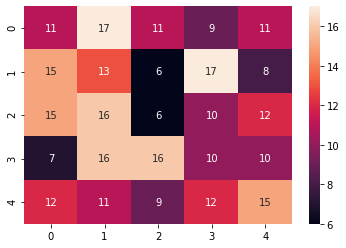

In [501]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))

#testar scalers ~ robust scaler.

clf.fit(training_lbp, training_value)

preds = clf.predict(testing_lbp)

sns.heatmap(confusion_matrix(testing_value, preds), annot=True)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


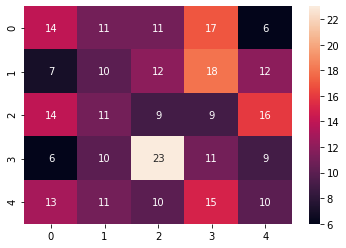

In [502]:


logReg = LogisticRegression(random_state=9, solver='newton-cg', max_iter=1000, multi_class='ovr')
## solver {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, default=’lbfgs’

logReg.fit(training_lbp, training_value)

preds = logReg.predict(testing_lbp)

sns.heatmap(confusion_matrix(testing_value, preds), annot=True)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


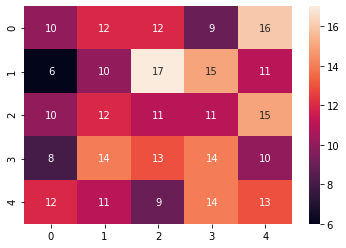

In [507]:
## TESTAR


from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification


clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(training_lbp, training_value)

preds = clf.predict(testing_lbp)

sns.heatmap(confusion_matrix(testing_value, preds), annot=True)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


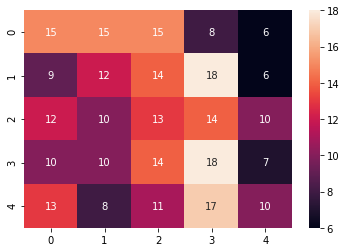

In [505]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

clf = RandomForestClassifier(max_depth=10, random_state=9)
clf.fit(training_lbp, training_value)

preds = clf.predict(testing_lbp)

sns.heatmap(confusion_matrix(testing_value, preds), annot=True)


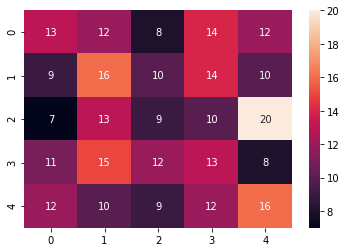

In [503]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=0)

clf.fit(training_lbp, training_value)

preds = clf.predict(testing_lbp)

sns.heatmap(confusion_matrix(testing_value, preds), annot=True)

